In [0]:
!pip install -q kaggle


In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"codotron","key":"4bda5f6cdea9c1b44066cecd6f7d4f43"}'}

In [0]:
!mkdir ~/.kaggle

In [0]:
!cp kaggle.json ~/.kaggle/

In [0]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [0]:
! chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews -p /content

 35% 9.00M/25.7M [00:00<00:00, 31.6MB/s]
100% 25.7M/25.7M [00:00<00:00, 64.2MB/s]


In [0]:
!unzip imdb-dataset-of-50k-movie-reviews.zip

Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


In [0]:
import pandas as pd

df_imdb = pd.read_csv('IMDB Dataset.csv')
df_imdb.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [0]:
trn_texts = df_imdb.loc[10000:14999, 'review'].values
trn_labels = df_imdb.loc[10000:14999, 'sentiment'].values
val_texts = df_imdb.loc[36000:38999, 'review'].values
val_labels = df_imdb.loc[36000:38999, 'sentiment'].values

In [0]:
import numpy as np

np.random.seed(42)
trn_idx = np.random.permutation(len(trn_texts))
val_idx = np.random.permutation(len(val_texts))

In [0]:
trn_texts = trn_texts[trn_idx]
val_texts = val_texts[val_idx]

trn_labels = trn_labels[trn_idx]
val_labels = val_labels[val_idx]

col_names = ['labels','text']
df_trn = pd.DataFrame({'text':trn_texts, 'labels':trn_labels}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':val_labels}, columns=col_names)

In [0]:
from fastai import *
from fastai.text import *

data_lm = TextLMDataBunch.from_df('./', train_df=df_trn, valid_df=df_val)

In [0]:
data_lm.show_batch()

idx,text
0,") is desperate to move east , and to see him selling his spread to xxmaj lee xxmaj wilkison ( xxmaj edward xxup g. xxmaj robinson ) . \n \n xxmaj parrish is not even much of a xxunk but he do understand that there is something big building up in the valley xxmaj in the xxmaj army , they used to call it '"
1,have a short walk - on role . xxmaj but somehow they manage to keep xxmaj morgan xxmaj freeman as xxmaj god . xxmaj while sitting in the near empty theater bored out of my mind at the lack of comedy i could n't help but wonder how much money it took to secure xxmaj freeman for this film . xxmaj then it hit me an hour ago . xxmaj
2,"'s supremely well done and captivating viewing throughout : the best film from this director that i 've seen , and among the very best of its genre . xxbos xxmaj here 's why this movie fell very short of its xxunk do n't read much , so i do n't care xxup what the novel was like ) . 1 . i think xxmaj brendan xxmaj frasier copied his"
3,"'s a shame , because there was a lot of talent , both musically and otherwise , in xxmaj the xxmaj monkees . xxmaj it 's probably odder that xxmaj rafelson , who directs here and co - produces with xxmaj schneider , and xxmaj jack xxmaj nicholson ( yes , _ that _ xxmaj jack xxmaj nicholson ) , who wrote the script and also co - produces ,"
4,again . xxmaj only after you see the closing credits do you get an idea of who is who . xxmaj after you know that you can watch it again with renewed appreciation . xxmaj do n't listen to the people that tear this movie apart . xxmaj it 's not for everyone . xxmaj if you 're someone that does n't like reading subtitles than this movie is n't


In [0]:
data_lm.train_ds[0][0].data[:10]

array([   2,   22,    5,    9,    5, 1159,    5,  371,   22, 5027])

In [0]:
import os
#os.chdir('./drive/My Drive/Colab Notebooks/')


data_lm.save('tmp_lm')

#data_lm = TextClasDataBunch.load('./', 'tmp_lm')

In [0]:
learner = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

In [0]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


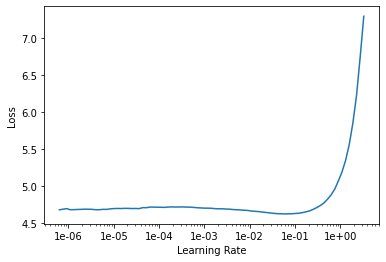

In [0]:
learner.recorder.plot()

In [0]:
learner.unfreeze()
learner.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.195406,3.983962,0.294724,03:36


In [0]:
learner.predict("This is a review about", n_words=10)

'This is a review about NOOKIE : CARES VERY TALE ,'

In [0]:
learner.save_encoder('fine_enc')

In [0]:
data_clas = TextClasDataBunch.from_df('./', train_df=df_trn, valid_df=df_val, vocab=data_lm.train_ds.vocab, bs=32)

In [0]:
classifier = text_classifier_learner(data_clas, AWD_LSTM,drop_mult=0.5)
classifier.load_encoder('fine_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (5000 items)
x: TextList
xxbos " xxmaj the xxmaj violent xxmaj men " marked the finest collaboration of xxmaj rudolph xxmaj xxunk with xxmaj glenn xxmaj ford in an intensely satisfying drama of rugged primitive justice 
 
 
  xxmaj ford is xxmaj john xxmaj parrish , a former xxmaj cavalry captain who is xxunk to get married and start a new life 
  xxmaj his fiancée xxmaj caroline xxmaj xxunk ( xxmaj may xxmaj wynn ) is desperate to move east , and to see him selling his spread to xxmaj lee xxmaj wilkison ( xxmaj edward xxup g. xxmaj robinson ) . 
 
  xxmaj parrish is not even much of a xxunk 
  but he do understand that there is something big building up in the valley 
  xxmaj in the xxmaj army , they used to call it ' enemy pressure . ' xxmaj first , xxmaj cole xxmaj wilkison ( xxmaj brian xxmaj keith ) comes back from xxmaj texas to help his brother run xxmaj anchor 
  xxmaj then a tough kid with a fancy gun ( xxmaj richard xxmaj j

In [0]:


classifier.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [0]:
classifier.fit_one_cycle(1, 1e-1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.434436,0.350989,0.845667,02:20


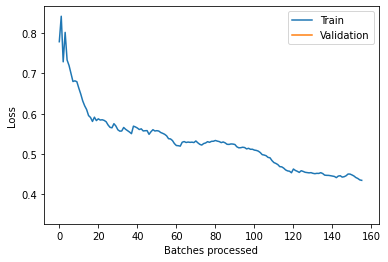

In [0]:
classifier.recorder.plot_losses()

In [0]:
classifier.save("trained_model", return_path=True)

PosixPath('models/trained_model.pth')

In [0]:
classifier.export("trained-model.pkl")

In [0]:
classifier.predict("The Google Pixel 4 is the worst phone ever released")

(Category tensor(0), tensor(0), tensor([0.9286, 0.0714]))

In [0]:

reloaded=load_learner("/content","trained-model.pkl")

In [0]:
x= reloaded.predict("The Google Pixel 4 has an excellent battery life, It also has a large screen that is notch less and gives user an amazing experience!")

In [0]:
print(x[2][1].item())


0.9984397292137146
